<a href="https://colab.research.google.com/github/Apaulgithub/Transformer_variants_for_text_classification/blob/main/Fine_tuning_Pretrained_Transformers_for_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets transformers scikit-learn

In [ ]:
# Import necessary libraries
from datasets import load_dataset
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          TrainingArguments, Trainer)
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [ ]:
# Download IMDb data using Hugging Face Datasets
dataset = load_dataset("imdb")
# For speed, use a subset (increase size for higher accuracy)
small_train = dataset["train"].shuffle(seed=42).select(range(2000))
small_test = dataset["test"].shuffle(seed=42).select(range(1000))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
# Define models to compare
model_names = [
    "bert-base-uncased",
    "distilbert-base-uncased",
    "roberta-base"
]

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

results = {}

for model_name in model_names:
    print(f"Training {model_name} ...")
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    def preprocess(examples):
        return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=128)

    train_ds = small_train.map(preprocess, batched=True)
    test_ds = small_test.map(preprocess, batched=True)
    train_ds = train_ds.rename_column("label", "labels")
    test_ds = test_ds.rename_column("label", "labels")
    train_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
    test_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

    # Load model
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2,
        attn_implementation="eager"
    )
    model.to(device)

    training_args = TrainingArguments(
        output_dir=f'./results/{model_name}',
        num_train_epochs=5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        save_strategy="no",
        logging_dir='./logs',
        disable_tqdm=True,
    )

    def compute_metrics(pred):
        labels = pred.label_ids
        preds = np.argmax(pred.predictions, axis=1)
        acc = accuracy_score(labels, preds)
        prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
        return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=test_ds,
        compute_metrics=compute_metrics
    )

    trainer.train()
    eval_results = trainer.evaluate()
    results[model_name] = eval_results
    print(f"{model_name}: {eval_results}")

Using device: cuda
Training bert-base-uncased ...


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: aripaul05 (aripaul05-university-of-kalyani) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


{'loss': 0.4369, 'grad_norm': 3.904994010925293, 'learning_rate': 3.004e-05, 'epoch': 2.0}
{'loss': 0.127, 'grad_norm': 0.048442475497722626, 'learning_rate': 1.004e-05, 'epoch': 4.0}
{'train_runtime': 450.362, 'train_samples_per_second': 22.204, 'train_steps_per_second': 2.776, 'train_loss': 0.23312984008789062, 'epoch': 5.0}
{'eval_loss': 0.8820948004722595, 'eval_accuracy': 0.844, 'eval_precision': 0.8280632411067194, 'eval_recall': 0.8586065573770492, 'eval_f1': 0.8430583501006036, 'eval_runtime': 7.2012, 'eval_samples_per_second': 138.865, 'eval_steps_per_second': 17.358, 'epoch': 5.0}
bert-base-uncased: {'eval_loss': 0.8820948004722595, 'eval_accuracy': 0.844, 'eval_precision': 0.8280632411067194, 'eval_recall': 0.8586065573770492, 'eval_f1': 0.8430583501006036, 'eval_runtime': 7.2012, 'eval_samples_per_second': 138.865, 'eval_steps_per_second': 17.358, 'epoch': 5.0}
Training distilbert-base-uncased ...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.4069, 'grad_norm': 44.12541580200195, 'learning_rate': 3.004e-05, 'epoch': 2.0}
{'loss': 0.0988, 'grad_norm': 0.032051194459199905, 'learning_rate': 1.004e-05, 'epoch': 4.0}
{'train_runtime': 124.852, 'train_samples_per_second': 80.095, 'train_steps_per_second': 10.012, 'train_loss': 0.20714917221069337, 'epoch': 5.0}
{'eval_loss': 0.9252354502677917, 'eval_accuracy': 0.836, 'eval_precision': 0.8151750972762646, 'eval_recall': 0.8586065573770492, 'eval_f1': 0.8363273453093812, 'eval_runtime': 3.6216, 'eval_samples_per_second': 276.124, 'eval_steps_per_second': 34.516, 'epoch': 5.0}
distilbert-base-uncased: {'eval_loss': 0.9252354502677917, 'eval_accuracy': 0.836, 'eval_precision': 0.8151750972762646, 'eval_recall': 0.8586065573770492, 'eval_f1': 0.8363273453093812, 'eval_runtime': 3.6216, 'eval_samples_per_second': 276.124, 'eval_steps_per_second': 34.516, 'epoch': 5.0}
Training roberta-base ...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.5043, 'grad_norm': 93.68177032470703, 'learning_rate': 3.004e-05, 'epoch': 2.0}
{'loss': 0.308, 'grad_norm': 0.25281137228012085, 'learning_rate': 1.004e-05, 'epoch': 4.0}
{'train_runtime': 247.8702, 'train_samples_per_second': 40.344, 'train_steps_per_second': 5.043, 'train_loss': 0.3598264862060547, 'epoch': 5.0}
{'eval_loss': 0.6741493940353394, 'eval_accuracy': 0.845, 'eval_precision': 0.8271119842829077, 'eval_recall': 0.8627049180327869, 'eval_f1': 0.8445336008024072, 'eval_runtime': 7.1076, 'eval_samples_per_second': 140.694, 'eval_steps_per_second': 17.587, 'epoch': 5.0}
roberta-base: {'eval_loss': 0.6741493940353394, 'eval_accuracy': 0.845, 'eval_precision': 0.8271119842829077, 'eval_recall': 0.8627049180327869, 'eval_f1': 0.8445336008024072, 'eval_runtime': 7.1076, 'eval_samples_per_second': 140.694, 'eval_steps_per_second': 17.587, 'epoch': 5.0}


                         eval_accuracy  eval_precision  eval_recall   eval_f1
bert-base-uncased                0.844        0.828063     0.858607  0.843058
distilbert-base-uncased          0.836        0.815175     0.858607  0.836327
roberta-base                     0.845        0.827112     0.862705  0.844534


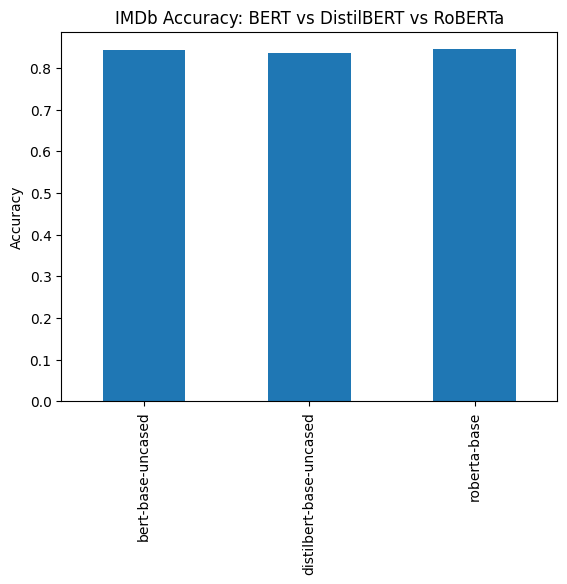

In [ ]:
# Print as DataFrame for easy viewing
df = pd.DataFrame(results).T
print(df[["eval_accuracy", "eval_precision", "eval_recall", "eval_f1"]])

# Plot accuracy comparison
df[["eval_accuracy"]].plot(kind='bar', legend=False)
plt.ylabel("Accuracy")
plt.title("IMDb Accuracy: BERT vs DistilBERT vs RoBERTa")
plt.show()

In [ ]:
!pip install bertviz

In [ ]:
# Example for BERT: Visualize attention weights with proper attention implementation
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Use attn_implementation="eager" to avoid the SDPA warning
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    attn_implementation="eager"  # Fix for attention visualization
)
model.to(device)
model.eval()  # Set to evaluation mode

inputs = tokenizer("This is an amazing movie!", return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}  # Move inputs to GPU

with torch.no_grad():
    outputs = model(**inputs, output_attentions=True)
    attentions = outputs.attentions  # List of layers, each tensor shape: [batch, heads, tokens, tokens]

# Print attention info
print(f"Number of attention layers: {len(attentions)}")
print(f"Attention shape (layer 0): {attentions[0].shape}")  # [batch_size, heads, seq_len, seq_len]

# For visualization with BertViz (if installed):
from bertviz import head_view, model_view

# Get tokens for visualization
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

# Visualize head view (individual attention heads)
head_view(attentions, tokens)

# Or model view (aggregated across heads per layer)
# model_view(attentions, tokens)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of attention layers: 12
Attention shape (layer 0): torch.Size([1, 12, 8, 8])


<IPython.core.display.Javascript object>